In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import time,math

# Data PreProcessing

In [334]:
use_cuda = False

In [301]:
SOS_token = 0
EOS_token = 1
PAD_token = 2
UNK_token = 3

class Lang:
    
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS" , 2: "PAD" , 3:"UNK"}
        self.n_words = 3  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [302]:
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [303]:
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [304]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [305]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [306]:
def prepareData(lang1, lang2, reverse=False, filter_pair=True):
    
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    if filter_pair:
        pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4490
eng 2926
['vous commettez une grosse erreur .', 'you re making a big mistake .']


In [307]:
def indexesFromSentence(lang, sentence, max_len ):
    arr = [PAD_token]*max_len
    
    for idx,word in enumerate( sentence.split(' ') ):
        arr[idx] = lang.word2index[word]
        
    arr[idx+1] = EOS_token
    return arr


def variableFromSentence(lang, sentence, max_len):
    indexes = indexesFromSentence(lang, sentence,max_len)
    result = torch.LongTensor(indexes)
    if use_cuda:
        return result.cuda()
    else:
        return result


def variablesFromPair(pair, input_lang, output_lang, in_max, out_max ):
    input_variable = variableFromSentence( input_lang, pair[0], in_max)
    target_variable = variableFromSentence( output_lang, pair[1], out_max)
    return (input_variable, target_variable)

In [308]:
class lang2lang( Dataset ):
    
    def __init__( self, pairs, input_lang, output_lang, in_max, out_max ):
        super(lang2lang,self).__init__()
        self.pairs = pairs
        self.input_lang = input_lang
        self.output_lang = output_lang
        self.in_max = in_max
        self.out_max = out_max
    
    def __len__( self ):    
        return len( self.pairs )
    
    def __getitem__( self, idx ):
        
        input_variable=variableFromSentence(self.input_lang, self.pairs[ idx][0], self.in_max)
        target_variable=variableFromSentence(self.output_lang, self.pairs[ idx][1], self.out_max)
        
        return { "input":input_variable , "target":target_variable }

In [309]:
dataset = lang2lang( pairs, input_lang, output_lang, 10, 10)

In [463]:
dataloader = DataLoader( dataset,batch_size=16,shuffle=False,num_workers=4 )

# Transformer Model and sublayers

In [466]:
class Softmax3D( nn.Module ):
    
    def __init__( self ):
        super( Softmax3D, self ).__init__()
    
    def forward( self, x ):
        s0,s1,s2 = x.size()
        return F.softmax( x.view(s0*s1,s2) ).view( s0,s1,s2 )

In [467]:
class ScaledAttention( nn.Module ):
    '''Scaled dot product attention mechanism basis of Attention is all you need
       three things required query key value,
       key and value are always same,
       when self attention query is also the same
       when not query is from the decoder'''
    
    def __init__( self, d , dropout=0.1 , n_head=1):
        
        super( ScaledAttention, self).__init__()
        self.scale = np.power(d, 0.5)
        self.dropout = nn.Dropout(dropout)
        self.softmax = Softmax3D()
        self.n_head = n_head

    def forward( self , query , key , value , attn_mask=None ):
        attn_val = torch.bmm( query , key.transpose(1,2) ) / self.scale
        
        if attn_mask is not None:
            attn_val.data.masked_fill_( attn_mask.repeat(self.n_head,1,1) , -float('inf') )
        
        attn_val = self.softmax(attn_val)
        attn_val = self.dropout(attn_val)
        output   = torch.bmm( attn_val, value )
        
        return output , attn_val

In [468]:
class MultiHeadAttention( nn.Module ):
    
    def __init__( self , d_model, n_head , dropout=0.1):
        super( MultiHeadAttention, self ).__init__()
        
        assert d_model%n_head == 0 , "n_head({}) must divide d_model({})".format(n_head,d_model) 
        self.n_head = n_head
        self.d_model = d_model
        self.d_intermediate = self.d_model // self.n_head
        
        self.start_proj_q = nn.Linear(self.d_model, self.d_model)
        self.start_proj_k = nn.Linear(self.d_model, self.d_model)
        self.start_proj_v = nn.Linear(self.d_model, self.d_model)
        
        self.attention = ScaledAttention(self.d_intermediate, dropout, n_head)
        
        self.proj = nn.Linear(d_model,d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward( self , query , key , value , attn_mask=None ):
        batch_size = query.size(0)
        
        query = self.start_proj_q( query )
        key   = self.start_proj_k( key )
        value = self.start_proj_v( value )
        
        query = torch.cat( query.split( self.d_intermediate,-1 ) , 0)
        key   = torch.cat(   key.split( self.d_intermediate,-1 ) , 0)
        value = torch.cat( value.split( self.d_intermediate,-1 ) , 0)
        
        output, attn = self.attention(query, key, value, attn_mask )
        output = torch.cat( output.split( batch_size,0 ) , -1)
        
        output = self.proj( output )
        output = self.dropout( output )
        
        return output, attn

In [469]:
class PositionwiseFeedForward( nn.Module ):

    def __init__(self, d_model, d_inner=None, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        
        if d_inner==None:
            d_inner = 4*d_model
        
        self.proj = nn.Linear(d_model, d_inner) 
        self.proj_out = nn.Linear(d_inner, d_model) 
        self.dropout  = nn.Dropout(dropout)

    def forward(self, x):
        
        output = F.relu( self.proj(x) )
        output = self.proj_out(output)
        output = self.dropout(output)
        return output

In [470]:
class LayerNormalization(nn.Module):

    def __init__(self, d_model, eps=1e-3):
        super(LayerNormalization, self).__init__()

        self.eps = eps
        self.scale = nn.Parameter(torch.ones(d_model), requires_grad=True)
        self.offset = nn.Parameter(torch.zeros(d_model), requires_grad=True)

    def forward(self, z):
        if z.size(1) == 1:
            return z

        mu = torch.mean(z, keepdim=True, dim=-1)
        sigma = torch.std(z, keepdim=True, dim=-1)
        ln_out = (z - mu.expand_as(z)) / (sigma.expand_as(z) + self.eps)
        ln_out = ln_out * self.scale.expand_as(ln_out) + self.offset.expand_as(ln_out)

        return ln_out

In [471]:
class EncoderLayer( nn.Module ):
    
    def __init__( self, d_model, n_head ,dropout=0.1 ):
        
        super( EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention( d_model, n_head, dropout )
        self.feedforward = PositionwiseFeedForward( d_model, dropout=dropout )
        
        self.layer_normalization_att = LayerNormalization(d_model)
        self.layer_normalization_feed = LayerNormalization(d_model)
        
    def forward( self, enc_input, self_attn_mask=None ):
        
        enc_out, _ = self.attention(enc_input,enc_input,enc_input,self_attn_mask )
        enc_out = self.layer_normalization_att( enc_out + enc_input )
        
        enc_out = self.layer_normalization_feed( self.feedforward(enc_out) + enc_out )
        return enc_out , _

In [472]:
class DecoderLayer(nn.Module):

    def __init__(self, d_model, n_head, dropout=0.1):
        
        super(DecoderLayer, self).__init__()
        
        self.self_attention = MultiHeadAttention(d_model, n_head, dropout=dropout)
        self.enc_attention = MultiHeadAttention(d_model, n_head, dropout=dropout)
        self.feedforward = PositionwiseFeedForward(d_model, dropout=dropout)
        
        self.layer_normalization_self = LayerNormalization(d_model)
        self.layer_normalization_enc  = LayerNormalization(d_model)
        self.layer_normalization_feed = LayerNormalization(d_model)
        
    def forward(self, dec_input, enc_output, self_attn_mask=None, enc_attn_mask=None):
        
        dec_output, _ = self.self_attention(dec_input, dec_input, dec_input, attn_mask=self_attn_mask)
        dec_input = self.layer_normalization_self( dec_input + dec_output )
        
        dec_output, __ = self.enc_attention(dec_input, enc_output, enc_output, attn_mask=enc_attn_mask)
        dec_output = self.layer_normalization_enc( dec_input + dec_output )
        
        dec_output = self.layer_normalization_feed( self.feedforward(dec_output) + dec_output )

        return dec_output, _ , __

In [473]:
def position_encoding_init(n_position, d_pos_vec):
    ''' Init the sinusoid position encoding table '''

    position_enc = np.array( [ [pos / np.power(10000, 2*i/d_pos_vec) for i in range(d_pos_vec)]
                                if pos != 0 else np.zeros(d_pos_vec) 
                                for pos in range(n_position) ] )

    position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2]) # dim 2i
    position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2]) # dim 2i+1
    return torch.from_numpy(position_enc).type(torch.FloatTensor)

def get_attn_padding_mask(seq_q, seq_k):
    ''' Indicate the padding-related part to mask '''
    
    assert seq_q.dim() == 2 and seq_k.dim() == 2
    
    mb_size, len_q = seq_q.size()
    mb_size, len_k = seq_k.size()
    
    pad_attn_mask = seq_k.data.eq( PAD_token ).unsqueeze(1)   # bx1xsk
    pad_attn_mask = pad_attn_mask.expand(mb_size, len_q, len_k) # bxsqxsk
    
    return pad_attn_mask

def get_attn_subsequent_mask(seq):
    ''' Get an attention mask to avoid using the subsequent info.'''
    
    assert seq.dim() == 2
    
    attn_shape = (seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    subsequent_mask = torch.from_numpy(subsequent_mask)
    
    return subsequent_mask

In [474]:
class Encoder(nn.Module):

    def __init__( self, src_vocab , max_seq_len, n_layers=6, n_head=8, d_word_vec=512, d_model=512, dropout=0.1):

        super(Encoder, self).__init__()

        self.d_model = d_model

        self.position_enc = nn.Embedding( max_seq_len+1, d_word_vec )
        self.position_enc.weight.data = position_encoding_init(max_seq_len+1, d_word_vec)

        self.src_word_emb = nn.Embedding( src_vocab, d_word_vec, padding_idx=PAD_token)

        self.layer = nn.ModuleList( [EncoderLayer(d_model, n_head, dropout=dropout) for _ in range(n_layers)] )

    def forward(self, src_seq, src_pos):
       
        enc_input = self.src_word_emb(src_seq)
        enc_input += self.position_enc(src_pos)
        
        enc_outputs, enc_self_attns = [], []
        enc_output = enc_input
        
        self_attn_mask = get_attn_padding_mask(src_seq, src_seq)
        
        for enc_layer in self.layer:
            
            enc_output, enc_self_attn = enc_layer( enc_output, self_attn_mask=self_attn_mask)
    
            enc_outputs.append( enc_output )
            enc_self_attns.append( enc_self_attn )

        return enc_outputs, enc_self_attns

In [475]:
class Decoder(nn.Module):
    
    def __init__( self, tgt_vocab, max_seq_len, n_layers=6, n_head=8, d_word_vec=512, d_model=512, dropout=0.1):

        super(Decoder, self).__init__()
        
        self.max_seq_len = max_seq_len
        self.d_model = d_model

        self.position_enc = nn.Embedding( max_seq_len+1, d_word_vec )
        self.position_enc.weight.data = position_encoding_init( max_seq_len+1, d_word_vec)

        self.tgt_word_emb = nn.Embedding( tgt_vocab, d_word_vec, padding_idx=PAD_token )
        self.dropout = nn.Dropout(dropout)

        self.layer = nn.ModuleList( [ DecoderLayer(d_model, n_head, dropout=dropout) for _ in range(n_layers) ] )

    def forward(self, tgt_seq, tgt_pos, src_seq, enc_outputs):
        
        dec_input = self.tgt_word_emb(tgt_seq)
        dec_input += self.position_enc(tgt_pos)

        dec_outputs, dec_self_attns, dec_enc_attns = [], [], []

        dec_self_attn_pad_mask = get_attn_padding_mask(tgt_seq, tgt_seq)
        dec_self_attn_sub_mask = get_attn_subsequent_mask(tgt_seq)
        
        dec_self_attn_mask     = torch.gt(dec_self_attn_pad_mask + dec_self_attn_sub_mask, 0)
        dec_enc_attn_pad_mask  = get_attn_padding_mask(tgt_seq, src_seq)

        dec_output = dec_input
        
        for dec_layer, enc_output in zip(self.layer, enc_outputs):
            
            dec_output, dec_self_attn, dec_enc_attn = dec_layer( dec_output, enc_output, 
                                                                 self_attn_mask = dec_self_attn_mask,
                                                                 enc_attn_mask  = dec_enc_attn_pad_mask )

            dec_outputs.append( dec_output )
            dec_self_attns.append( dec_self_attn )
            dec_enc_attns.append( dec_enc_attn )

        return dec_outputs, dec_self_attns, dec_enc_attns

In [500]:
class Transformer(nn.Module):
    ''' Attention is all you need '''

    def __init__( self, src_vocab, tgt_vocab, max_seq_len, n_layers=6, n_head=8, d_word_vec=512, d_model=512,
                  dropout=0.1, embs_share_weight=False):

        super(Transformer, self).__init__()
        
        assert d_model == d_word_vec,'To facilitate the residual connections.'
        
        self.encoder = Encoder( src_vocab, max_seq_len, n_layers=n_layers, n_head=n_head,
                                d_word_vec=d_word_vec, d_model=d_model, dropout=dropout )
        
        self.decoder = Decoder( tgt_vocab, max_seq_len, n_layers=n_layers, n_head=n_head,
                                d_word_vec=d_word_vec, d_model=d_model, dropout=dropout)
        
        self.tgt_word_proj = nn.Linear(d_model, tgt_vocab, bias=False)
        self.dropout = nn.Dropout(dropout)

        if embs_share_weight:
            assert src_vocab == tgt_vocab,"To share word embedding,The vocabulary size of src/tgt must be same"
            self.encoder.src_word_emb.weight = self.decoder.tgt_word_emb.weight

    def get_trainable_parameters(self):
        ''' Avoid updating the position encoding '''
        
        enc_freezed_param_ids = set(map(id, self.encoder.position_enc.parameters()))
        dec_freezed_param_ids = set(map(id, self.decoder.position_enc.parameters()))
        freezed_param_ids = enc_freezed_param_ids | dec_freezed_param_ids
        
        return (p for p in self.parameters() if id(p) not in freezed_param_ids)

    def forward(self, src, tgt):
        src_seq, src_pos = src
        tgt_seq, tgt_pos = tgt

        enc_outputs, enc_slf_attns = self.encoder(src_seq, src_pos)
        dec_outputs, dec_slf_attns, dec_enc_attns = self.decoder( tgt_seq, tgt_pos, src_seq, enc_outputs)
        dec_output = dec_outputs[-1]
        
        seq_logit = self.tgt_word_proj(dec_output)
        
        sz = seq_logit.size()
        log_loss = F.log_softmax( seq_logit.view(-1, seq_logit.size(2)) )
        return log_loss.view( sz )

In [518]:
teacher_forcing_ratio = 0.75

def train(input_variable, target_variable, model, optimizer, criterion, max_seq_len ):
    
    batch_size = input_variable.size(0)
    
    input_pos = Variable( torch.LongTensor( range(1,max_seq_len+1) ).view(1,-1).repeat(batch_size,1) )
    target_pos = input_pos.clone()

    optimizer.zero_grad()    
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        
        teacher_forcing_target = Variable( torch.LongTensor([[SOS_token]]*batch_size ) )
        teacher_forcing_target = torch.cat( ( teacher_forcing_target,target_variable[:,:-1]), dim=1)

        output = model( (input_variable,input_pos) , (teacher_forcing_target,target_pos) )
    
    else:
        
        output , output_generated = eval( input_variable, max_seq_len , model )
                
    loss = criterion( output.view(-1,output.size(2) ), target_variable.view(-1) )

    _ , max_index = output.data.topk(1)
    correct = ( max_index.view(-1) == target_variable.data.view(-1) ).sum()

    loss.backward()
    optimizer.step()

    return loss.data[0] / 10 , correct

In [558]:
def eval(input_variable, max_seq_len, model ):
    
    batch_size = input_variable.size(0)
    
    input_pos  = Variable( torch.LongTensor( range(1,max_seq_len+1) ).view(1,-1).repeat(batch_size,1) )
    target_pos = input_pos.clone()
    
    target_var = Variable( torch.LongTensor( [[PAD_token]]*batch_size ).repeat(1,max_seq_len) )
    target_var[:,0] = SOS_token

    for index in range(1,max_seq_len):

        output = model( (input_variable,input_pos ), (target_var,target_pos ) )
        correct_indices = output.topk(1)[1].squeeze(2)

        for i in range(batch_size):
            
            PADDING_REQ = (target_var[i,index-1].data[0]==EOS_token or target_var[i,index-1].data[0]==PAD_token)
            target_var[i,index] = PAD_token if PADDING_REQ else correct_indices[i,index-1]  
            
    # we return the output to be used by the train instance
    # and the target_var 
    target_var = output.topk(1)[1].squeeze(2)
        
    return output, target_var

In [519]:
def trainIters(model, max_seq_len, print_every=100, plot_every=100, learning_rate=0.01):

    optimizer = optim.Adam( model.get_trainable_parameters() ,lr=learning_rate)
    
    criterion = nn.NLLLoss(ignore_index=PAD_token)
    
    plot_losses = []
    
    for epoch in range(100):    
        
        print_loss_total = 0  
        plot_loss_total = 0  

        for iter,X in enumerate(dataloader):

            input_variable  = Variable( X['input'] )
            target_variable = Variable( X['target'] )

            loss , correct = train(input_variable, target_variable, model, optimizer, criterion,
                                   max_seq_len , epoch==99)
            print_loss_total += loss
            plot_loss_total  += loss
            
            if iter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                
                if iter==0:
                    print_loss_avg *= print_every
                print_loss_total = 0
                print('%d: %.4f' % ( epoch,  print_loss_avg))
                total = target_variable.data.ne(PAD_token).sum()
                print("current batch correct are: {}/{} = {:.6f}".format(correct,total,correct/total) )

            if iter % plot_every == 0:
                plot_loss_avg = plot_loss_total / print_every
                
                if iter==0:
                    plot_loss_avg *= print_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0
            
#             here training only a single batch of data 
#             because dont want to blow up my computer
            
#             if iter == 0:
#                 break
                
    plt.plot(plot_losses)

0: 0.8168
current batch correct are: 0/79 = 0.000000
1: 0.7522
current batch correct are: 0/79 = 0.000000
2: 0.7194
current batch correct are: 2/79 = 0.025316
3: 0.6991
current batch correct are: 16/79 = 0.202532
4: 0.6799
current batch correct are: 3/79 = 0.037975
5: 0.6586
current batch correct are: 16/79 = 0.202532
6: 0.6354
current batch correct are: 17/79 = 0.215190
7: 0.6105
current batch correct are: 18/79 = 0.227848
8: 0.5844
current batch correct are: 18/79 = 0.227848
9: 0.5585
current batch correct are: 32/79 = 0.405063
10: 0.5347
current batch correct are: 32/79 = 0.405063
11: 0.5103
current batch correct are: 32/79 = 0.405063
12: 0.4849
current batch correct are: 33/79 = 0.417722
13: 0.4593
current batch correct are: 32/79 = 0.405063
14: 0.4329
current batch correct are: 32/79 = 0.405063
15: 0.4058
current batch correct are: 32/79 = 0.405063
16: 0.3790
current batch correct are: 32/79 = 0.405063
17: 0.3532
current batch correct are: 32/79 = 0.405063
18: 0.3283
current batch

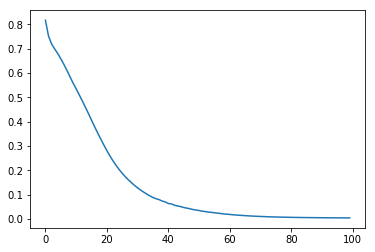

In [520]:
model = Transformer( input_lang.n_words, output_lang.n_words, max_seq_len=10, n_layers=2, n_head=2,
                     d_word_vec = 12, d_model = 12, dropout = 0 )

trainIters(model, 10, print_every=500 ,learning_rate=0.01)

In [530]:
model

Transformer (
  (encoder): Encoder (
    (position_enc): Embedding(11, 12)
    (src_word_emb): Embedding(4490, 12, padding_idx=2)
    (layer): ModuleList (
      (0): EncoderLayer (
        (attention): MultiHeadAttention (
          (start_proj_q): Linear (12 -> 12)
          (start_proj_k): Linear (12 -> 12)
          (start_proj_v): Linear (12 -> 12)
          (attention): ScaledAttention (
            (dropout): Dropout (p = 0)
            (softmax): Softmax3D (
            )
          )
          (proj): Linear (12 -> 12)
          (dropout): Dropout (p = 0)
        )
        (feedforward): PositionwiseFeedForward (
          (proj): Linear (12 -> 48)
          (proj_out): Linear (48 -> 12)
          (dropout): Dropout (p = 0)
        )
        (layer_normalization_att): LayerNormalization (
        )
        (layer_normalization_feed): LayerNormalization (
        )
      )
      (1): EncoderLayer (
        (attention): MultiHeadAttention (
          (start_proj_q): Linear (12 ->